# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
%%javascript
// Disables cell autoscrolling. Code borrowed from
// https://bit.ly/3xBL7HR

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Specify a max of 100 rows for displayed Dataframes
pd.options.display.max_rows = 100

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
def my_load(filename, func=pd.read_csv, *args, **kwargs):
    udacity_path = '../../data/Term2/capstone/arvato_data'.split('/')
    full_path = os.path.join(*udacity_path, filename)
    
    errors = []
    
    try:
        df = func(full_path, **kwargs)
        return df
    except Exception as e:
        errors.append(e)
    
    try:
        df = func(filename, **kwargs)
        return df
    except Exception as e:
        errors.append(e)
    
    if errors:
        raise Exception(errors)
#     raise Exception('Error when loading the file...\
#     Please check the path is either current directory or ../../data/Term2/capstone/arvato_data ')

In [5]:
# load in the data
azdias = my_load('Udacity_AZDIAS_052018.csv', sep= ';')
customers = my_load('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Mohammed\miniconda3\envs\DSND_Cap_Clone\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


The first thing to notice is the warning about columns 18 and 19 being of mixed types (shown below). We will investigate that later. However, let us start by just looking at the basic structure of the data (azdias)

In [6]:
azdias.iloc[:,17:19].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,8A,8
2,4C,4
3,2A,2
4,6B,6


In [7]:
azdias.iloc[:,18].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

Looks like the `X` represents missing values

In [8]:
azdias.iloc[:,17].value_counts()

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64

Looks like the `XX` represents missing values

In [9]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


Looks like the data is relatively big with a disk space of 2.4+ GB and 366 columns of which 267 are float, 93 are ints, and 6 are either strings or mixed.<br>
The first step is to identify unknown values (nans). For that, the `DIAS Attributes - Values 2017.xlsx` file is needed. Upon a quick skim over that file, it seems that the nans are signaled in the `Meaning` column by either the phrase `unknown` or `no ... known ...`. The most approach to handle this is by filtering the rows by the `known` phrase then extracting corresponding values from the `Value` column 

In [11]:
def get_unknown_meanings():
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    df = df[df.Meaning.str.contains('known')]
    df.to_csv('tmp.csv')
    return df
unknowns = get_unknown_meanings()
unknowns.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown


Just to make sure that we don't have irrelevant rows, I will print all different values of Meaning

In [12]:
set(unknowns.Meaning.values)

{'company building w/o known company ',
 'mixed building without actually known company ',
 'mixed building without actually known household ',
 'mixed building without actually known household or comapny ',
 'no transaction known',
 'no transactions known',
 'residental building buildings without actually known household',
 'unknown',
 'unknown / no main age detectable'}

It turns out that the phrases that indicate missing values are only the following:
<ul>
    <li>unknown</li>
    <li>unknown / no main age detectable</li>
    <li>no transaction known</li>
    <li>no transactions known</li>
</ul>

In [13]:
def get_unknown_meanings_updated():
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    lst_of_unknowns = ['unknown',
                       'unknown / no main age detectable',
                       'no transaction known',
                       'no transactions known'
                      ]
    df = df[df.Meaning.str.contains('|'.join(lst_of_unknowns))]
    df.to_csv('tmp2.csv')
    return df
unknowns = get_unknown_meanings_updated()
unknowns.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown


In [14]:
unknown_vals = unknowns[['Attribute', 'Value']].set_index('Attribute').astype({'Value':str})

In [15]:
set(unknowns.Meaning.values)

{'no transaction known',
 'no transactions known',
 'unknown',
 'unknown / no main age detectable'}

It is important to remember that not all the attributes mentioned in the Attribute file contain unknown indicators. So, it is good to list those attributes here as they.<br>
<br>
Now that we are doing with identifying missing values specified in the Attribute file, it is time to add back the columns that were specified in the Attribute file but contained none of the `unknown` catch phrases mentioned above

In [16]:
def get_non_unknown_meanings(unknown_vals):
    df = my_load('DIAS Attributes - Values 2017.xls', func=pd.read_excel)
    df.ffill(inplace=True)
    
    attributes_of_interest = set(df.Attribute.unique()) - set(unknown_vals.index) 
    return attributes_of_interest

cols_with_no_unknowns = get_non_unknown_meanings(unknown_vals)
cols_with_no_unknowns

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'CAMEO_DEU_2015',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'GEBAEUDETYP_RASTER',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'KBA13_ANZAHL_PKW',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'MIN_GEBAEUDEJAHR',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'PLZ8_BAUMAX'}

In [17]:
len(cols_with_no_unknowns)

25

In [18]:
print(f'Looks like there are {len(set(unknowns.Attribute.values))} \
different attributes that need to be addressed in terms of identifying \
missing values. And, there are {len(cols_with_no_unknowns)} \
columns that don\'t have missing values indicators')

Looks like there are 289 different attributes that need to be addressed in terms of identifying missing values. And, there are 25 columns that don't have missing values indicators


However, upon further inspection, it turns out that there are differences between the columns specified in the Attributes sheet and the columns found in the AZDIAS dataframe. <br>

In [19]:
df = azdias.copy()

In [20]:
def parse_missing_and_unknown(entry):
    def is_number(s):
        try:
            float(s)
            return True
        except ValueError:
            return False
    
    lst = entry.split(',')
    lst = [float(num) if is_number(num) else num for num in lst]
    return lst



In [21]:
print(f'For example, There are {len(set(unknown_vals.index) - set(df.columns))} columns that we can identify nans for \
but are not available in the AZDIAS dataframe')
print(f'On the other hand, there are {len(set(df.columns) - set(unknown_vals.index)  ) - len(cols_with_no_unknowns)} columns which we don\'t have information to identify nans with, since \
they are not mentioned in the Attribute sheet but available in the AZDIAS dataframe' )
print(f'Fortunately, there are {len(set(df.columns) & set(unknown_vals.index)) + len(cols_with_no_unknowns)} columns that overlap and we can identify nans for')

For example, There are 42 columns that we can identify nans for but are not available in the AZDIAS dataframe
On the other hand, there are 94 columns which we don't have information to identify nans with, since they are not mentioned in the Attribute sheet but available in the AZDIAS dataframe
Fortunately, there are 272 columns that overlap and we can identify nans for


On the good side, the majority of the columns can be processed easily, since they are overlapping between the 2 sheets. However, there is a large number of columns that are remaining. Those remaining columns are going to be addressed individually if there turned out to be a need to include them for further analysis. However, most likely, these columns are going to be dropped, because cleanliness of the data that is produced at this step is of top priority. Another reason is that learning models don't perform well (or not at all) with missing values.  

In [20]:
Print('These are some of the remaining columns mentioned above')
set(unknown_vals.index) - set(df.columns) 

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

it seems that there are multiple columns that are found in the Attribute sheet and cannot be found in the AZDIAS data. However, several of those have a very similar corresponding column names. For example, `D19_BANKEN_GROSS_RZ` is found in the Attributes and not in AZDIAS. However, `D19_BANKEN_GROSS` can be found in AZDIAS. There could be several reasons for this. One reason would be that these are different and unrelated columns. However, it is also possible that this is only a mismatch in the column names based on factors like (data storage database or differently located server). In other words, it could represent a lack of synchronization between the 2 files. Another possibility is that these are different stages of storing the same data, or that they were undergone different processing or preprocessing phases<br>
Let's count how many of these columns are found

In [21]:
def get_columns_with_similar_names():
    lst1 = list(set(unknown_vals.index) - set(df.columns) )
    lst2 = list(set(df.columns) - set(unknown_vals.index) )
    
    lst1 = [e[:-3] if e.endswith('_RZ') else e for e in lst1 ]
    return list(set(lst1) & set(lst2))
print(f'There are {len(get_columns_with_similar_names())} such columns')
get_columns_with_similar_names()

There are 33 such columns


['D19_BANKEN_DIREKT',
 'D19_VERSICHERUNGEN',
 'D19_SAMMELARTIKEL',
 'D19_FREIZEIT',
 'D19_BANKEN_LOKAL',
 'D19_BIO_OEKO',
 'D19_SONSTIGE',
 'D19_KINDERARTIKEL',
 'D19_TIERARTIKEL',
 'D19_BANKEN_GROSS',
 'D19_KOSMETIK',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_TELKO_REST',
 'D19_DIGIT_SERV',
 'D19_LOTTO',
 'D19_TELKO_MOBILE',
 'D19_ENERGIE',
 'D19_SCHUHE',
 'D19_REISEN',
 'D19_VOLLSORTIMENT',
 'D19_RATGEBER',
 'D19_WEIN_FEINKOST',
 'D19_BILDUNG',
 'D19_HAUS_DEKO',
 'D19_GARTEN',
 'D19_DROGERIEARTIKEL',
 'D19_BEKLEIDUNG_GEH',
 'D19_LEBENSMITTEL',
 'D19_HANDWERK',
 'D19_VERSAND_REST',
 'D19_TECHNIK',
 'D19_BEKLEIDUNG_REST',
 'D19_BANKEN_REST']

These columns could be used in our analysis. However, it is really hard to prove that the columns found in the Attribute file correspond to the ones that are similar from AZDIAS. Therefore, they are going to be dropped for now. However, if a need arises to use them, then they can be potentially used with careful pre-processing/inspection.<br>
<br>
For now, we are sticking with the column names that are overlapping between the 2 files (mentioned in Attribute and AZDIAS)<br>
The next step is to replace the values specified by the Value column to nans.

In [22]:
# replace values specified in Attribute with NaNs
for col in list(set(unknown_vals.index) & set(df.columns)):
    lst_of_values_to_be_converted_to_nans = parse_missing_and_unknown(unknown_vals['Value'][col])
    df.loc[df[col].isin(lst_of_values_to_be_converted_to_nans), col] = np.nan

In [25]:
azdias.shape,df.shape

((891221, 366), (891221, 366))

In [23]:
azdias.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [24]:
df.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
0.0     8340
Name: AGER_TYP, dtype: int64

Looks like missing values are detected and replaced properly. However, there is more cleaning to do. Some columns appear to be categorical, while others appear to be mixed. Careful handling needs to be used to address each of those.<br>
However, before we start with that, one thing to do is to investigate the distribution of missing values in the dataset.<br>
As can be seen below, the number of rows with no missing values is 0 (even after filtering out the columns that were not cleaned in the previous step)

In [21]:
df = df[list(set(unknown_vals.index) & set(df.columns))]

In [22]:
df[~df.isnull().any(axis=1)].head()

,KBA13_SEG_VAN,D19_VERSAND_ANZ_24,FINANZ_ANLEGER,KBA13_CCM_3001,SEMIO_ERL,KBA05_KW1,KBA13_AUDI,ZABEOTYP,KBA13_ALTERHALTER_45,KBA13_SEG_UTILITIES,...,D19_VERSAND_OFFLINE_DATUM,KBA05_SEG8,KBA05_VORB2,REGIOTYP,TITEL_KZ,KBA13_FORD,FINANZTYP,D19_TELKO_OFFLINE_DATUM,KBA13_HALTER_25,KBA05_AUTOQUOT


This is just too few. I am suspecting that there is at least one column that contains lots of missing data. So, let's check the percentage of nans in each column 

In [23]:
num_of_nans = df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100
num_of_nans

TITEL_KZ                     99.757636
D19_TELKO_ONLINE_DATUM       99.079577
D19_BANKEN_OFFLINE_DATUM     97.791120
D19_TELKO_ANZ_12             96.271295
D19_BANKEN_ANZ_12            93.325225
D19_TELKO_ANZ_24             92.705176
D19_VERSI_ANZ_12             92.153237
D19_TELKO_OFFLINE_DATUM      91.909190
D19_BANKEN_ANZ_24            89.102479
D19_VERSI_ANZ_24             87.187914
D19_BANKEN_ONLINE_DATUM      81.571462
D19_BANKEN_DATUM             76.112547
AGER_TYP                     76.019640
D19_TELKO_DATUM              74.706274
D19_VERSAND_ANZ_12           71.584040
D19_VERSAND_OFFLINE_DATUM    71.164504
D19_GESAMT_ANZ_12            65.617507
D19_VERSAND_ANZ_24           63.263545
D19_GESAMT_OFFLINE_DATUM     62.673344
D19_GESAMT_ANZ_24            56.697834
D19_VERSAND_ONLINE_DATUM     55.481637
KBA05_BAUMAX                 53.468668
D19_GESAMT_ONLINE_DATUM      50.604171
D19_VERSAND_DATUM            49.133268
D19_GESAMT_DATUM             39.739863
ALTER_HH                 

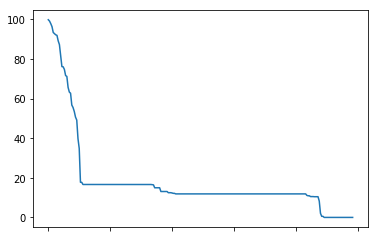

In [24]:
num_of_nans.plot()

In [34]:
import pickle
def get_remaining_after_dropping_columns(df, num_of_nans):
    times = []
    
    tmp = df.copy()
    initial_count_of_nans = tmp.count().sum()
    counts_of_non_nans = [100.]
    num_of_rows_without_nans = [0]
    t0 = time.time()
    times.append(t0)
    print(f'Starting ... {time.time() - t0:0.2f}sec')
    
    for i, col in enumerate(num_of_nans.index):
        print(f'{i:03d}\t{col}', end='\t')
        tmp = tmp.drop(columns=[col])
        try:
            counts_of_non_nans.append(tmp.count().sum()*100/initial_count_of_nans)
            num_of_rows_without_nans.append(len(tmp[~tmp.isnull().any(axis=1)].index))
        except Exception as e:
            print(str(e))
        new_time = time.time()-t0
        times.append(new_time)
        print(f'{new_time:0.2f}sec') 
    
    stored = {'times': times,
              'result': (counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans)
             }
    pickle.dump(stored, open(os.path.join('pickles', 'remaining_after_drop.pickle'), 'wb'))
    
    return counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans

try:
    stored = pickle.load(open(os.path.join('pickles', 'remaining_after_drop.pickle'),'rb'))
    times = stored['times']
    counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans = stored['result']
    
    print('Starting ... 0.00sec')
    for i, col in enumerate(num_of_nans.index):
        print(f'{i:03d}\t{col}\t{times[i+1]:0.2f}sec')
except (OSError, IOError) as e:
    counts_of_non_nans, initial_count_of_nans, num_of_rows_without_nans = get_remaining_after_dropping_columns(df, num_of_nans)

Starting ... 0.00sec
000	TITEL_KZ	4.89sec
001	D19_TELKO_ONLINE_DATUM	9.76sec
002	D19_BANKEN_OFFLINE_DATUM	14.63sec
003	D19_TELKO_ANZ_12	19.45sec
004	D19_BANKEN_ANZ_12	24.22sec
005	D19_TELKO_ANZ_24	29.06sec
006	D19_VERSI_ANZ_12	33.80sec
007	D19_TELKO_OFFLINE_DATUM	38.56sec
008	D19_BANKEN_ANZ_24	43.28sec
009	D19_VERSI_ANZ_24	48.04sec
010	D19_BANKEN_ONLINE_DATUM	52.76sec
011	D19_BANKEN_DATUM	57.44sec
012	AGER_TYP	62.11sec
013	D19_TELKO_DATUM	66.82sec
014	D19_VERSAND_ANZ_12	71.50sec
015	D19_VERSAND_OFFLINE_DATUM	76.18sec
016	D19_GESAMT_ANZ_12	80.88sec
017	D19_VERSAND_ANZ_24	85.57sec
018	D19_GESAMT_OFFLINE_DATUM	90.20sec
019	D19_GESAMT_ANZ_24	94.89sec
020	D19_VERSAND_ONLINE_DATUM	99.47sec
021	KBA05_BAUMAX	104.06sec
022	D19_GESAMT_ONLINE_DATUM	108.67sec
023	D19_VERSAND_DATUM	113.33sec
024	D19_GESAMT_DATUM	118.04sec
025	ALTER_HH	122.75sec
026	REGIOTYP	127.34sec
027	KKK	132.06sec
028	KBA05_AUTOQUOT	136.68sec
029	KBA05_HERST1	141.32sec
030	KBA05_HERST5	146.09sec
031	KBA05_KW2	150.69sec
032	KBA0

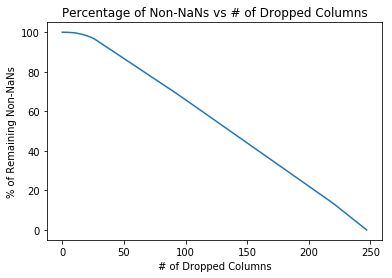

In [35]:
plt.plot(range(len(counts_of_non_nans)), counts_of_non_nans);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

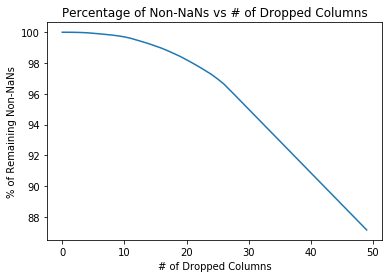

In [36]:
plt.plot(range(len(counts_of_non_nans[:50])), counts_of_non_nans[:50]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

Looks like the drop of starts around 25 columns. That means that even after dropping the top 25 columns with the most amount of missing values, we get to  used about 96% of the data found in the data set

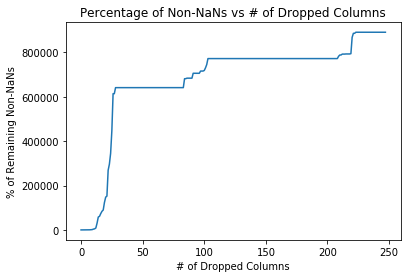

In [37]:
plt.plot(range(len(num_of_rows_without_nans)), num_of_rows_without_nans);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

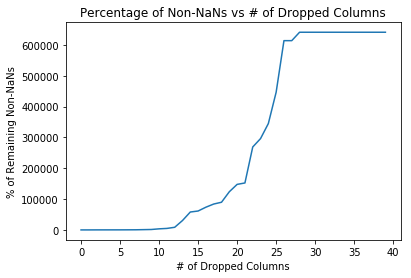

In [38]:
plt.plot(range(len(num_of_rows_without_nans[:40])), num_of_rows_without_nans[:40]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');

A similar conclusion can be drawn from counting the number of remaining rows with no missing values after dropping the columns. Looks like we need to zoom in to decide on the exact number

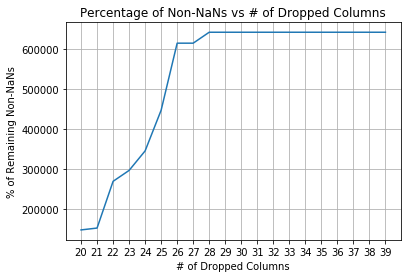

In [39]:
plt.plot(range(20, len(num_of_rows_without_nans[:40])), num_of_rows_without_nans[20:40]);
plt.title('Percentage of Non-NaNs vs # of Dropped Columns');
plt.ylabel('% of Remaining Non-NaNs');
plt.xlabel('# of Dropped Columns');
plt.xticks(np.arange(20,40));
plt.grid()

In [47]:
df = df.drop(columns=num_of_nans.index.values.tolist()[:26], errors='ignore')

Now that we have identified missing values for the numerical columns, let's take a look at columns of type string

In [54]:
df.select_dtypes(include='object').head()

,CAMEO_DEUG_2015,OST_WEST_KZ
0,NaN,NaN
1,8,W
2,4,W
3,2,W
4,6,W


In [56]:
tmp = df.select_dtypes(include="object").columns.values
print(f'Looks like there are {len(tmp)} such columns')
print(tmp)

Looks like there are 2 such columns
['CAMEO_DEUG_2015' 'OST_WEST_KZ']


Let us consider the values for the first of those columns

In [53]:
df.CAMEO_DEUG_2015.value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

Looks like the value `X` is invalid as it is not mentioned in the Attribute file. Let us convert that into NaN. Also, the floats and integers should be combined (e.g. 1 & 1.0).

In [67]:
df.loc[df.CAMEO_DEUG_2015 == 'X','CAMEO_DEUG_2015'] = np.nan
df.CAMEO_DEUG_2015 = df.CAMEO_DEUG_2015.astype(np.float)
df.CAMEO_DEUG_2015.value_counts()

8.0    134441
9.0    108177
6.0    105874
4.0    103912
3.0     86779
2.0     83231
7.0     77933
5.0     55310
1.0     36212
Name: CAMEO_DEUG_2015, dtype: int64

Looks good! <br>
Moving on to the other column

In [63]:
naming_mapping = {'OST_WEST_KZ':{'O':0,
                                     'W':1}}
df.replace(naming_mapping, inplace=True)
df.OST_WEST_KZ.value_counts()

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64

All good!

In [71]:
# This is done to manually check the values of the columns and that there are nothing that looks odd
with open('type-values.txt', 'w') as f:
    for col in df.columns:
        f.write(f'#########\n{col}\n')
        f.write(f'{df[col].value_counts()}\n\n')
    

All that remains is to clean/pre-process categorical and mixed columns

In [ ]:
#Need to add back columns from data but now found in Attribute. Just a reminder, these 

In [75]:
unknown_vals.head()

,Value
Attribute,
AGER_TYP,-1
ALTERSKATEGORIE_GROB,"-1, 0"
ALTER_HH,0
ANREDE_KZ,"-1, 0"
BALLRAUM,-1


In [74]:
set(azdias.columns)  - set(unknown_vals.index)  

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE'

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')